In [102]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from sklearn import svm, metrics, model_selection

# Extraction of the data

In [64]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
daily='csse_covid_19_daily_reports/' #date in the form  01-22-2020.csv
time_serie='csse_covid_19_time_series/' #+confirmed, death,recovered
confirmed_data='time_series_covid19_confirmed_global.csv'
death_data='time_series_covid19_deaths_global.csv'
recovered_data='time_series_covid19_recovered_global.csv'

In [67]:
confirmed=pd.read_csv(url+time_serie+confirmed_data)
dead=pd.read_csv(url+time_serie+death_data)
recovered=pd.read_csv(url+time_serie+recovered_data)

In [69]:
def date(day,month):   #convert a date in (day,month) format to a string to feed in the read_csv function
    day=str(day)
    month=str(month)
    if len(month)==1:
        month='0'+month
    date=month+'-'+day+'-2020.csv'
    return date

In [73]:
today=pd.read_csv(url+daily+date(28,3))

In [75]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


# Data Exploration

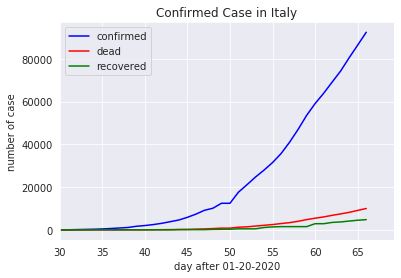

In [105]:
confirmed_italy=confirmed.iloc[137,4:]
dead_italy=dead.iloc[137,4:]
recovered_italy=recovered.iloc[137,4:]
confirmed_italy
time=np.arange(len(confirmed_italy))
plt.figure()
plt.title('Confirmed Case in Italy')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_italy,'b-',label='confirmed')
plt.plot(time,dead_italy,'r-',label='dead')
plt.plot(time,recovered_italy,'g-',label='recovered')
plt.legend()
plt.xlim(30)
plt.show()

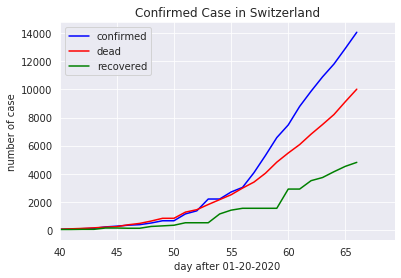

In [108]:

confirmed_swiss=confirmed.iloc[206,4:]
dead_swiss=dead.iloc[137,4:]
recovered_swiss=recovered.iloc[137,4:]
confirmed_swiss
time=np.arange(len(confirmed_swiss))
plt.figure()
plt.title('Confirmed Case in Switzerland')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_swiss,'b-',label='confirmed')
plt.plot(time,dead_swiss,'r-',label='dead')
plt.plot(time,recovered_swiss,'g-',label='recovered')
plt.legend()
plt.xlim(40)
plt.show()